In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Dense, InputLayer, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow import keras

In [ ]:
dataset, dataset_info= tfds.load("malaria",with_info=True, as_supervised=True, shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete2YR6FY/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpnqvq0weetfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [ ]:
Train_Ratio=0.8
Val_Ratio=0.1
Test_Ratio=0.1

In [ ]:
def splits(dataset,Train_Ratio,Val_Ratio,Test_Ratio):
  datasize=len(dataset)

  Train_dataset=dataset.take(int(Train_Ratio*datasize))

  Val_dataset=dataset.skip(int(Train_Ratio*datasize))
  Val_dataset=Val_dataset.take(int(Val_Ratio*datasize))

  Test_dataset=dataset.skip(int(datasize*(Train_Ratio+Val_Ratio)))

  return Train_dataset, Val_dataset, Test_dataset

In [ ]:
Train_dataset, Val_dataset, Test_dataset= splits(dataset[0], Train_Ratio, Val_Ratio, Test_Ratio)

## Dataset Visualization

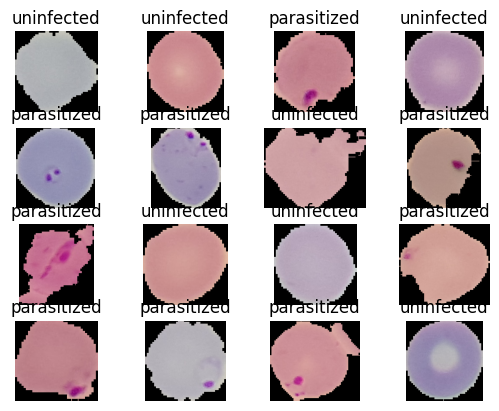

In [ ]:
for i, (image,label) in enumerate(Train_dataset.take(16)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## Data Preprocessing

In [ ]:
Im_size=224
def resize_rescale(image,label):
  return tf.image.resize(image,(Im_size,Im_size))/255.0, label

In [ ]:
Train_dataset=Train_dataset.map(resize_rescale)
Val_dataset=Val_dataset.map(resize_rescale)
Test_dataset=Test_dataset.map(resize_rescale)
Train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
Train_dataset=Train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
Val_dataset=Val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
Val_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
Train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model Creation and Training

In [ ]:
model=tf.keras.Sequential([InputLayer(input_shape=(Im_size,Im_size,3)),

                           tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                           BatchNormalization(),
                           MaxPool2D(pool_size=2, strides=2),

                           tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                           BatchNormalization(),
                           MaxPool2D(pool_size=2, strides=2),

                           Flatten(),

                           Dense(100,activation='relu'),
                           BatchNormalization(),
                           Dense(10,activation='relu'),
                           BatchNormalization(),
                           Dense(1,activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

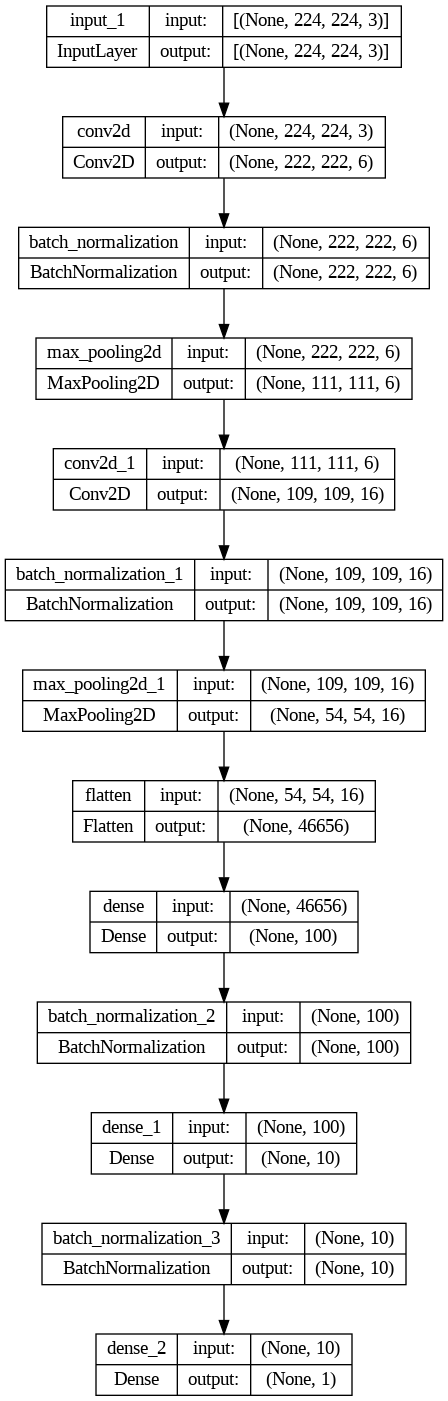

In [ ]:
tf.keras.utils.plot_model(model,to_file="Model.png",show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy')

In [ ]:
history= model.fit(Train_dataset, validation_data=Val_dataset, epochs = 20, verbose=1)

Epoch 1/20
689/689 [==============================] - 91s 115ms/step - loss: 0.3219 - accuracy: 0.8694 - val_loss: 0.8316 - val_accuracy: 0.6348
Epoch 2/20
689/689 [==============================] - 71s 102ms/step - loss: 0.1949 - accuracy: 0.9335 - val_loss: 0.3952 - val_accuracy: 0.8207
Epoch 3/20
689/689 [==============================] - 51s 74ms/step - loss: 0.1801 - accuracy: 0.9410 - val_loss: 0.3504 - val_accuracy: 0.8711
Epoch 4/20
689/689 [==============================] - 48s 70ms/step - loss: 0.1649 - accuracy: 0.9466 - val_loss: 0.2676 - val_accuracy: 0.8918
Epoch 5/20
689/689 [==============================] - 54s 78ms/step - loss: 0.1639 - accuracy: 0.9461 - val_loss: 0.3838 - val_accuracy: 0.8236
Epoch 6/20
689/689 [==============================] - 56s 81ms/step - loss: 0.1545 - accuracy: 0.9500 - val_loss: 0.9765 - val_accuracy: 0.5267
Epoch 7/20
689/689 [==============================] - 49s 71ms/step - loss: 0.1482 - accuracy: 0.9509 - val_loss: 0.3405 - val_accurac

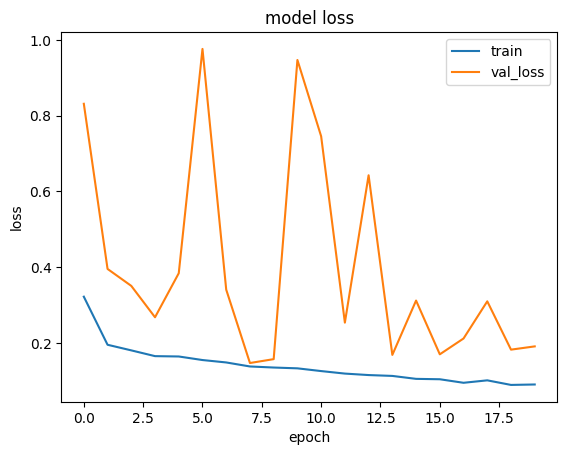

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

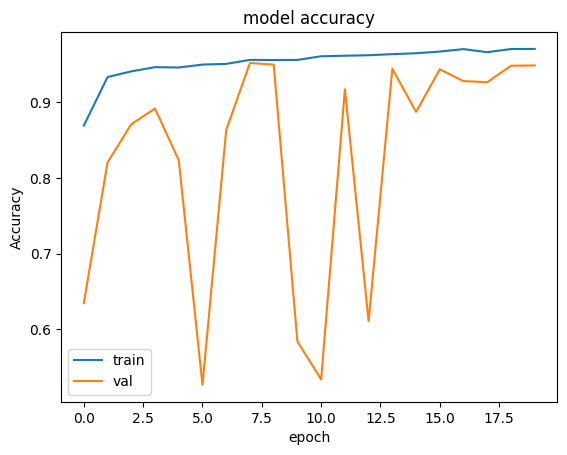

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

## Model Evaluation and Testing

In [ ]:
Test_dataset=Test_dataset.batch(1)
model.evaluate(Test_dataset)

2756/2756 [==============================] - 26s 4ms/step - loss: 0.2017 - accuracy: 0.9390


[0.20171138644218445, 0.9390420913696289]

In [ ]:
def parasite_or_not(x):
  if x>0.5:
    return "P"
  else:
    return "U"


1/1 [==============================] - 0s 28ms/step


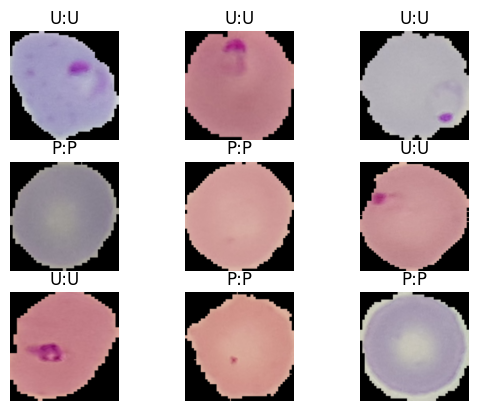

In [ ]:
for i, (image,label) in enumerate(Train_dataset.take(9)):
  x=plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis("off")

In [ ]:
model.save("LeNet_model.keras")

In [ ]:
new_model=keras.models.load_model("LeNet_model.keras")

In [ ]:
new_model.evaluate(Test_dataset)

2756/2756 [==============================] - 28s 3ms/step - loss: 0.2014 - accuracy: 0.9387


[0.20140764117240906, 0.9386792182922363]